In [15]:
import os, sys, pathlib, importlib
sys.path.append('../')

# Load the package and modules for training and plotting
import nsbi_common_utils
from nsbi_common_utils import plotting, training, datasets, configuration
from nsbi_common_utils.training import TrainEvaluate_NN, TrainEvaluatePreselNN


import tensorflow as tf
tf.config.optimizer.set_jit(False)
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Nadam
import mplhep as hep
import matplotlib.pyplot as plt
import pickle
import yaml
import random

from utils import preselection_using_score, calculate_preselection_observable

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

hep.style.use(hep.style.ATLAS)

In [16]:
## TODOs
## read from a serialized config file, "we" convert it into some object from a well-defined class, 
## user modify the object as user needs, and then at the end of the step, "we" write again to the serialized config
## define mutable vs immutable information

config = nsbi_common_utils.configuration.ConfigManager(file_path_string = './config.yml')

In [17]:
# Input features for training
features, features_scaling = config.get_training_features()

In [18]:
importlib.reload(sys.modules['nsbi_common_utils.datasets'])
from nsbi_common_utils import datasets

Datasets = nsbi_common_utils.datasets.datasets(config_path = './config.yml',
                                                branches_to_load = features)

In [19]:
# Get the dictionary of labels to processes
train_label_sample_dict = {"htautau"        : 0,
                            "ttbar"         : 1,
                            "ztautau"       : 2}

In [20]:
dataset_incl_dict = Datasets.load_datasets_from_config(load_systematics = True)

dataset_incl_nominal = dataset_incl_dict["Nominal"].copy()

In [21]:
dataset_incl_nominal_training = Datasets.merge_dataframe_dict_for_training(dataset_incl_nominal, 
                                                                            train_label_sample_dict,
                                                                            samples_to_merge = dataset_incl_nominal.keys())

Training the Preselection NN
===

**Choice of reference sample**

The density ratios need to be trained on phase space regions with support for the reference hypothesis $p_{ref}(x) > 0$.

To ensure this, we make a selection that selects events in the phase space regions with $p_{ref}(x) > 0$, or $p_c(x) \gg p_{ref}(x)$, and only perform the NSBI fit in this selected analysis region. **A natural choice for the reference hypothesis is then the signal-rich hypotheses**. This is referred to in the ATLAS publications as the Search-Oriented Mixture Models approach: 

$$p_{ref}(x) = \frac{1}{\sum_S \nu_S} \sum_S \frac{d\sigma_S}{dx} = \frac{1}{\nu_{H \to \tau\tau}} \frac{d\sigma_{H \to \tau\tau}}{dx}$$

where the sum runs over all signal hypothesis in the model and the second equality is due to the sole signal hypothesis in our toy model, $pp \to {t\bar{t}}$. 

**Selecting out regions with $p_{ref}\sim 0$**

A multi-class classification NN, with softmax output, is trained to output a score:

$$ \text{NN}_\text{presel} = \log \left[\frac{\sum_S P_S (x)}{\sum_B P_B(x)} \right]$$

where $P_c$ are the probability scores outputted from the softmax layer of the trained NN.



In [29]:
importlib.reload(sys.modules['nsbi_common_utils.training'])
from nsbi_common_utils.training import TrainEvaluatePreselNN

PATH_PRESEL_MODEL = './saved_data/preselection_model/'

# If the preselection NN has already been trained and saved, load from the saved model
USE_SAVED_MODEL_PRESEL = True

features, features_scaling = config.get_training_features()

preselectionTraining = TrainEvaluatePreselNN(dataset_incl_nominal_training, 
                                            features, 
                                            features_scaling)

if not USE_SAVED_MODEL_PRESEL:
    preselectionTraining.train(test_size=0.2, 
                                random_state=42, 
                                path_to_save=PATH_PRESEL_MODEL,
                                batch_size=4096,
                                epochs=50, 
                                learning_rate=0.1)

else:
    preselectionTraining.assign_trained_model(PATH_PRESEL_MODEL)


In [30]:
for region_name, dataset_sample_dict in dataset_incl_dict.items():

    for sample_name, dataset in dataset_sample_dict.items():

        # Get predictions (softmax outputs)
        pred_NN_incl = preselectionTraining.predict(dataset)

        presel_score = calculate_preselection_observable(pred_NN_incl, 
                                                        train_label_sample_dict, 
                                                        signal_processes       = ['htautau'], 
                                                        background_processes   = ['ttbar', 'ztautau'], 
                                                        pre_factor_dict        = {'htautau': 1.0, 'ttbar': 1.0, 'ztautau': 1.0})

        dataset_incl_dict[region_name][sample_name]['presel_score'] = presel_score


(1509069, 3)
(1509069, 8)
(1476602, 3)
(1476602, 8)
(1517220, 3)
(1517220, 8)
(1508198, 3)
(1508198, 8)
(1517202, 3)
(1517202, 8)
(1475760, 3)
(1475760, 8)
(1509900, 3)
(1509900, 8)
(1517233, 3)
(1517233, 8)
(1477316, 3)
(1477316, 8)
(1509070, 3)
(1509070, 8)
(1517223, 3)
(1517223, 8)
(1476692, 3)
(1476692, 8)
(1509051, 3)
(1509051, 8)
(1517221, 3)
(1517221, 8)
(1476483, 3)
(1476483, 8)


In [ ]:
Datasets.add_appended_branches(['presel_score'])
Datasets.save_datasets(dataset_incl_dict, save_systematics = True)

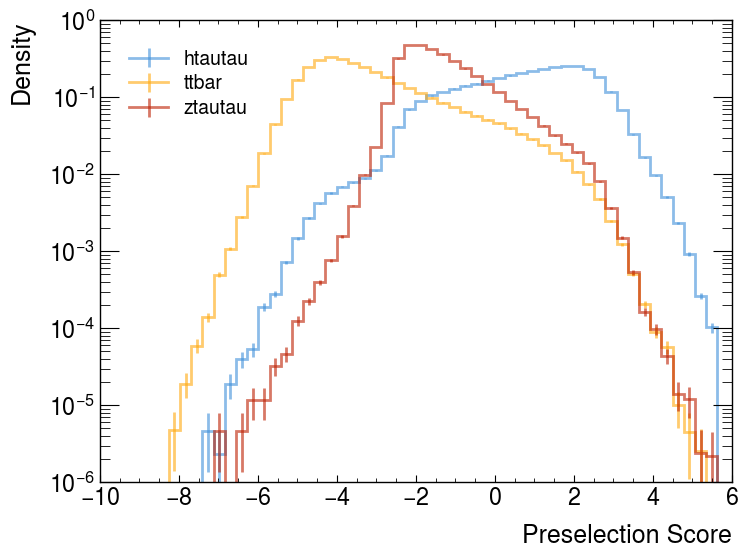

In [11]:
min_pred = np.amin(presel_score)
max_pred = np.amax(presel_score)

bins = np.linspace(min_pred, max_pred, num=50)

hist_NN_output          = {}
hist_NN_output_errs     = {}

presel_score_arr        = {}

for sample_name, sample_dataset in dataset_incl_dict["Nominal"].items():

    presel_score_arr    = sample_dataset['presel_score']
    weights             = sample_dataset['weights']

    hist_NN_output[sample_name], _          = np.histogram(presel_score_arr, weights = weights,     bins=bins)
    
    hist_NN_output_errs[sample_name], _     = np.histogram(presel_score_arr, weights = weights**2,  bins=bins)

    hep.histplot(hist_NN_output[sample_name], bins=bins, 
             alpha=0.6, label=sample_name, 
             density=True, linewidth=2.0, yerr = np.sqrt(hist_NN_output_errs[sample_name]))

plt.xlabel("Preselection Score", size=18)
plt.ylabel("Density", size=18)
plt.legend()
plt.yscale('log')
plt.show()

Making the cut
===

Make a selection cut for regions with $p_{ref} \gg 0$ for performing the NSBI analysis. The remaining events - which by definition are background-dominated - can be used as a **Control Region** for data-driven background estimation, pre-unblinding validations, etc. 

Moreover, the preselections act as a tuning know for the tradeoff in selecting as many signal events as possible to go into the **Signal Region** (increasing sensitivity) and the feasibility of training accurate and precise NNs over a large phase space (need bigger models and more statistics). **The preselections can also weed out phase space regions with low background statistics to avoid poorly modelled regions.** 

Heres a first cut that you can optimize as much as you like to get the desired final results. 

In [12]:
# Play around with these selections - decrease if estimators are unbiased but need more sensitivity and increase if the model is biased to reduce complexity
preselection_cuts = {'upper': 4.5, 'lower': -1.}

## Convert to an object that takes inputs - better for dynamic changing

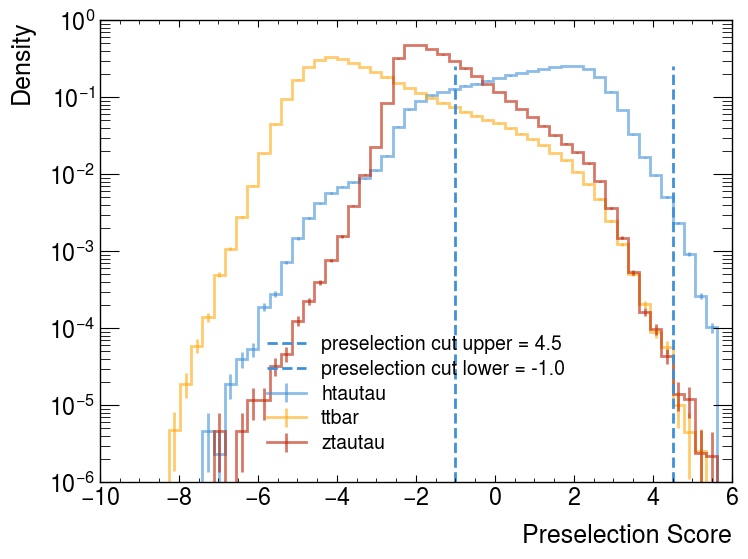

In [13]:

for sample_name, sample_dataset in dataset_incl_dict["Nominal"].items():

    hep.histplot(hist_NN_output[sample_name], bins=bins, 
             alpha=0.6, label=sample_name, 
             density=True, linewidth=2.0, yerr = np.sqrt(hist_NN_output_errs[sample_name]))

for key in preselection_cuts:
    if preselection_cuts[key] != -999:
        plt.axvline(preselection_cuts[key], ymax=0.9, linestyle='--', label=f'preselection cut {key} = {preselection_cuts[key]}')


plt.xlabel("Preselection Score", size=18)
plt.ylabel("Density", size=18)
plt.legend()
plt.yscale('log')
plt.show()

In [ ]:
for key in train_label_sample_dict:  
    hep.histplot(hist_NN_output[key], bins = bins, 
             alpha = 0.6, label = key, 
             density = True, linewidth = 2.0, 
                 yerr = np.sqrt(hist_NN_output_errs[key]))

plt.xlabel("Preselection Score", size=18)

for key in preselection_cuts:
    if preselection_cuts[key] != -999:
        plt.axvline(preselection_cuts[key], ymax=0.9, linestyle='--', label=f'preselection cut {key} = {preselection_cuts[key]}')

plt.ylabel("Density", size=18)
plt.legend()
plt.yscale('log')
plt.show()

In [ ]:
for key in train_label_sample_dict:  
    hep.histplot(hist_NN_output[key], bins = bins, 
             alpha = 0.6, label = key, 
             density = False, linewidth = 2.0, 
                 yerr = np.sqrt(hist_NN_output_errs[key]))

plt.xlabel("Preselection Score", size=18)

for key in preselection_cuts:
    if preselection_cuts[key] != -999:
        plt.axvline(preselection_cuts[key], ymax=0.9, linestyle='--', label=f'preselection cut {key} = {preselection_cuts[key]}')

plt.ylabel("Density", size=18)
plt.legend()
plt.yscale('log')
plt.show()

Signal and Control Regions
===

The high signal over background phase space towards the right of the preselection cut shown above will be categorized as the **Signal Region** where the NSBI analysis is performed.

The low signal phase space towards the left will be used as a **Control Region**, with typical uses such as background estimation, pre-unblinding data-MC checks, etc. In this phase space, we will use a binned summary observable like in any traditional analysis.

In [ ]:
importlib.reload(sys.modules['utils'])
from utils import preselection_using_score

channel_selections = {'CR': {'observable': 'presel_score', 
                             'preselections': f"presel_score<{preselection_cuts.get('lower')}",
                             'num_bins': 4},
                      
                      'SR_binned': {'observable': 'presel_score', 
                                    'preselections': f"presel_score>{preselection_cuts.get('upper')}",
                                    'num_bins': 1},
                      
                      'SR': {'observable': None, 
                             'preselections': f"presel_score>={preselection_cuts.get('lower')} & presel_score<={preselection_cuts.get('upper')}"
                            }}


dataset_channels = preselection_using_score(dataset_incl_nominal, channel_selections)


In [ ]:
# Build a summary observable for binned Signal/Control Regions
hist_binned = {}
bins = {}

config.update(
    {
        "Regions": []
    }
)

for channel, dict_observable in channel_selections.items():

    hist_binned[channel] = {}

    fit_observable = dict_observable['observable']

    config["Regions"].append(
    {
            "Name": channel,
            "Filter": channel_selections[channel]['preselections'],
            "Variable": channel_selections[channel]['observable'],
            "Binning": None
        },
    )

    if fit_observable == None: continue

    kin_variable = dataset_channels[channel][fit_observable].to_numpy()

    min_kin = np.amin(kin_variable)
    max_kin = np.amax(kin_variable)

    num_bin_edges = dict_observable['num_bins'] + 1

    bins[channel] = np.linspace(min_kin, max_kin, num = num_bin_edges)

    config["Regions"][-1]["Binning"] = bins[channel].astype(float).tolist()

    # Use the high-level preselection NN score as a summary observable for Control Region
    for process in train_label_sample_dict:
        dataset_process = dataset_channels[channel][dataset_channels[channel].detailed_labels==process]
        hist_binned[channel][process], bins[channel] = np.histogram(np.clip(dataset_process[fit_observable], min_kin, max_kin),
                                    weights = dataset_process['weights'].ravel(),
                                    bins = bins[channel])

    # # Save the Control Region observable
    # with open(f"{PATH_TO_SAVED_DATA}hist_binned_{channel}.pkl", "wb") as fp:
    #     pickle.dump(hist_binned[channel], fp)

    # np.save(f"{PATH_TO_SAVED_DATA}bins_{channel}.npy", bins)

In [ ]:
hist_binned['SR_binned']['htautau']

array([1.603611], dtype=float32)

Text(0, 1, 'Density')

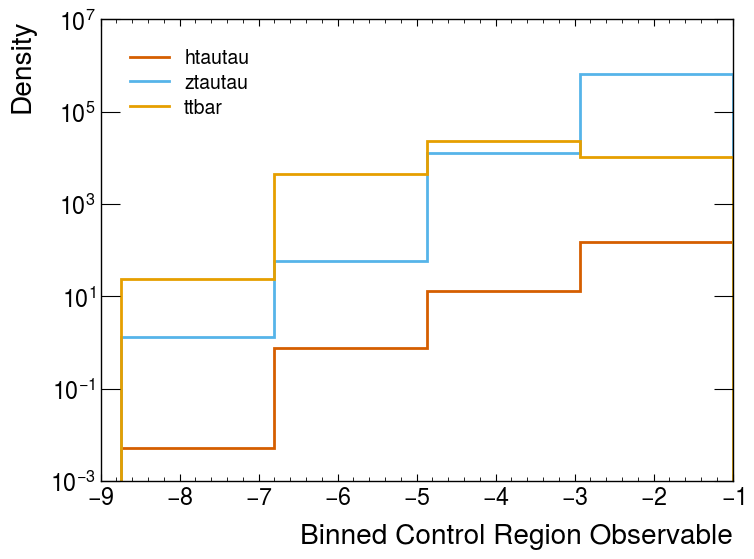

In [ ]:
# Plot the Control Region observable

channel = 'CR'

for process in train_label_sample_dict:
    
    hep.histplot(hist_binned[channel][process], bins = bins[channel], label=process, linewidth=2.0)

plt.legend()
plt.xlabel('Binned Control Region Observable')
plt.yscale('log')
plt.ylabel('Density')

Text(0, 1, 'Density')

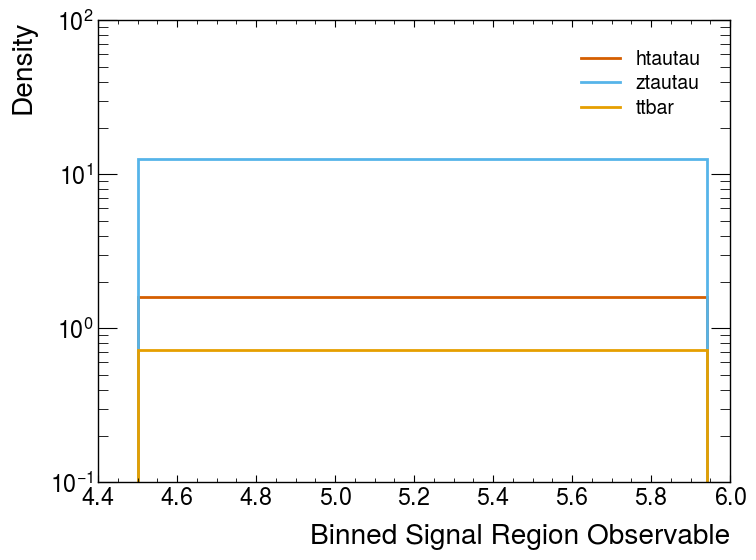

In [ ]:
# Plot the Control Region observable

channel = 'SR_binned'

for process in train_label_sample_dict:
    
    hep.histplot(hist_binned[channel][process], bins[channel], label=process, linewidth=2.0)

plt.legend()
plt.xlabel('Binned Signal Region Observable')
plt.yscale('log')
plt.ylabel('Density')

In [ ]:
# # Save the preselected Nominal dataframe for inference use later on
dataset_incl_nominal.to_hdf(f"{path_to_nominal_dataframe}", key="dataset", mode='w')


In [ ]:
for systematics_dict in config["Systematics"]:

    type_syst = systematics_dict.get("Type")
    if type_syst=="NormPlusShape":
        for variation in ["weight_up", "weight_dn"]:
            
            path_to_sample = systematics_dict[variation]
            df_syst = pd.read_hdf(path_to_sample, key="dataset", mode="r")

            # Get predictions (softmax outputs)
            pred_NN_incl = preselectionTraining.predict(df_syst)
            
            presel_score = calculate_preselection_observable(pred_NN_incl, 
                                                             train_label_sample_dict, 
                                                             signal_processes, 
                                                             background_processes)
            
            df_syst['presel_score'] = presel_score

            df_syst.to_hdf(f"{path_to_sample}", key="dataset", mode='w')
            

451/451 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
451/451 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
451/451 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
451/451 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


In [ ]:
# Save the updated YAML back to the file
with open('config.yml', 'w') as file:
    yaml.dump(
        config, file, 
        default_flow_style=False,
        sort_keys=False, indent=4, width=1000                 
             )